In [1]:
"""
PREDICTION LOOP:
Input: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,
                                                                  Period,
                                                                  Distribution,
                                                                  Price per volume,
                                                                  Price per volume without promo,
                                                                  Number of Categories,
                                                                  Number of Sub Categories,
                                                                  Category,
                                                                  Sub Category,
                                                                  Brand,
                                                                  }
Output: Predictions over 3Y + Sum over 3Y

"""

'\nPREDICTION LOOP:\nInput: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,\n                                                                  Period,\n                                                                  Distribution,\n                                                                  Price per volume,\n                                                                  Price per volume without promo,\n                                                                  Number of Categories,\n                                                                  Number of Sub Categories,\n                                                                  Category,\n                                                                  Sub Category,\n                                                                  Brand,\n                                                                  }\nOutput: Predictions over 3Y + Sum over 3Y\n\n'

In [1]:
import pickle
import json
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from prophet import Prophet
#import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
PATH_TO_INPUTS = 'assets/'

In [2]:
from sklearn.neighbors import NearestNeighbors

In [4]:
from datamanager.DM_USA import DM_USA

with open('assets/params.json', 'r') as f:
    json_sell_out_params = json.load(f)

data_manager=DM_USA()
data_manager.ad_hoc_USA(json_sell_out_params)
df = data_manager.get_df()

<open_excel> Loading data from file: data/Growth Modelling - USA - 2018-2021 - Sell-Out Data (IRI).xlsx


FileNotFoundError: [Errno 2] No such file or directory: 'data/Growth Modelling - USA - 2018-2021 - Sell-Out Data (IRI).xlsx'

In [5]:
df = pd.read_excel("data/USA/USA_df_postprocessing_0303.xlsx")
df.head()

,Date,Market,Category,Sub Category,Brand,Sales in value,Sales value with promo,Sales in volume,Sales volume with promo,Price without promo,Price with promo,Price per volume,Distribution,Period
0,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,285.014421,NaN,25.961137,NaN,10.978503,NaN,10.978503,0.013007,1
1,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,AUTHENTIC MENU,1205.790000,5.277200,242.500000,2.145000,4.994717,3.637500,4.972330,1.980134,1
2,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,APPEL FARM QUARK,391.079899,4.796178,80.904125,2.756167,4.966977,3.365000,4.833868,0.151621,1
3,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,ASHBYS,3909.132137,53.182613,327.681769,6.832235,12.025146,10.709200,11.929660,0.848531,1
4,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,NEW BRIDGE,27112.449008,995.316059,2707.353139,184.093633,10.455282,8.365867,10.014375,7.551650,1


In [16]:
df.Category.unique()

array(['CLASSIC SPREADS', 'CREAM CHEESE', 'ENTERTAINING TRAYS',
       'EVERYDAY BLOCKS', 'EVERYDAY SHREDDED & GRATED',
       'GOURMET BLOCK / WEDGE / ROUND', 'GOURMET CRUMBLED',
       'GOURMET FRESH ITALIAN', 'GOURMET SHREDDED / GRATED',
       'GOURMET SPREADS', 'PIMENTO', 'RICOTTA AND FARMERS', 'SLICES',
       'SNACK', 'SNACKING COMBOS', 'PLANT BASED'], dtype=object)

In [6]:
#set space for nn
df_temp = df.copy()

In [7]:
def build_train_set(df):
    df_temp = df.copy()
    df_temp = df_temp[["Category", "Sub Category", "Brand", "Distribution", "Price per volume", "Sales in volume"]]

    df_n_cat = df_temp.groupby(['Brand'])['Category'].agg(Number_of_Categories = "nunique").reset_index().rename(columns={'Number_of_Categories':'Number of Categories'})
    df_n_sub_cat = df_temp.groupby(['Brand', 'Category'])['Sub Category'].agg(Sub_Categories='nunique').reset_index().rename(columns={'Sub_Categories':'Number of Sub Categories'})

    df_temp = pd.merge(df_temp, df_n_cat, on="Brand", how="left")
    df_temp = pd.merge(df_temp, df_n_sub_cat, on=["Brand", 'Category'], how="left")

    df_sub = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()

    """compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
    Distribution = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
        {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
    )

    Price = df_temp.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
        {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
    )

    """merge high level metrics into df_sub"""
    df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

    df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])

    df_sub = df_sub.fillna(0.0)
    
    return df_sub

In [8]:
df_sub = build_train_set(df_temp)
df_sub_no_encoding = df_sub.copy()

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
df_sub.columns

Index(['Category', 'Sub Category', 'Brand', 'Number of Categories',
       'Number of Sub Categories', 'min Distribution', 'max Distribution',
       'mean Distribution', 'std Distribution', 'min Price', 'max Price',
       'mean Price', 'std Price'],
      dtype='object')

In [10]:
le_cat = LabelEncoder()
df_sub['Category'] = le_cat.fit_transform(df_sub['Category'])
le_sub_cat = LabelEncoder()
df_sub['Sub Category'] = le_sub_cat.fit_transform(df_sub['Sub Category'])
le_brand = LabelEncoder()
df_sub['Brand'] = le_brand.fit_transform(df_sub['Brand'])

In [11]:
le_cat.classes_

array(['CLASSIC SPREADS', 'CREAM CHEESE', 'ENTERTAINING TRAYS',
       'EVERYDAY BLOCKS', 'EVERYDAY SHREDDED & GRATED',
       'GOURMET BLOCK / WEDGE / ROUND', 'GOURMET CRUMBLED',
       'GOURMET FRESH ITALIAN', 'GOURMET SHREDDED / GRATED',
       'GOURMET SPREADS', 'PIMENTO', 'PLANT BASED', 'RICOTTA AND FARMERS',
       'SLICES', 'SNACK', 'SNACKING COMBOS'], dtype=object)

In [12]:
neigh = NearestNeighbors(n_neighbors=30, radius=0.4)
neigh.fit(df_sub)

NearestNeighbors(n_neighbors=30, radius=0.4)

In [13]:
def build_profile(neighbors, df_sub, df, le_brand, le_cat, le_sub_cat):
    
    df_temp = df_sub.iloc[neighbors]
    df_temp['Category'] = le_cat.inverse_transform(df_temp['Category'])
    df_temp['Sub Category'] = le_sub_cat.inverse_transform(df_temp['Sub Category'])
    df_temp['Brand'] = le_brand.inverse_transform(df_temp['Brand'])
    df_merge = pd.merge(df_temp[['Category', 'Sub Category', 'Brand']], df, on=['Category', 'Sub Category', 'Brand'], how='left')
    profile = df_merge.groupby('Date')['Sales in volume'].agg('mean')
    
    return profile



In [ ]:
target = targets.get('0')
target

In [4]:
"""Classifier, Forecaster"""
#classifier = pickle.load(open(PATH_TO_INPUTS + 'USA_classifier_7.sav', 'rb'))

forecaster = lgb.Booster(model_file=PATH_TO_INPUTS + 'USA_forecaster_7.txt')

In [5]:
"""Profiles"""
profiles = pd.read_csv(PATH_TO_INPUTS+"USA_profiles_7.csv")

In [259]:
"""Label Encoders"""
le_brand_forecast = pickle.load(open(PATH_TO_INPUTS + 'USA_encoder_brand_7.pkl', 'rb'))
le_sub_cat_forecast = pickle.load(open(PATH_TO_INPUTS + 'USA_encoder_sub_cat_7.pkl', 'rb'))
le_cat_forecast = pickle.load(open(PATH_TO_INPUTS + 'USA_encoder_cat_7.pkl', 'rb'))

In [188]:
"""Targets"""
# with open(PATH_TO_INPUTS + 'predictions_targets_USA.json', 'r') as f:
#         targets = json.load(f)['targets']

# target = targets[1]



In [26]:
def create_left_inputs(static_inputs):
    """
    """
    dt = static_inputs['Date']
    pd_dt = pd.Timestamp(dt)
    
    second_left_inputs = [static_inputs['Distribution'], 
                          static_inputs['Price per volume'], 
                          #static_inputs['Price per volume without promo'], 
                          static_inputs['Number of Categories'], 
                          static_inputs['Number of Sub Categories']]
    
    left_inputs_bis = [static_inputs['Category'],
                       static_inputs['Sub Category'],
                       static_inputs['Brand']]

    left_inputs = [static_inputs['Period'],
                   pd_dt.weekofyear, 
                   pd_dt.is_month_end, 
                   pd_dt.is_month_start] + left_inputs_bis + second_left_inputs
    
    return left_inputs

def update_sample_and_forecast(xgb, sales_lag, 
                               roll_mean, lags, alphas, 
                               static_inputs, period=39, weeks_per_period=1):
    """
    """

    forecasts, samples = [], []
    len_lags = len(lags)
    index_lags = [l-1 for l in lags]
        
    tdelta = dt.timedelta(weeks=weeks_per_period)
    static_inputs['Date'] += tdelta
    left_inputs = create_left_inputs(static_inputs)
    #right_inputs = create_ohe_inputs(*cat_info, ohe_columns=ohe_columns)
    sales_lag = np.log1p(sales_lag)
    
    for p in range(period):
        sales_roll_mean = []
        sales_emw = {alpha:[] for alpha in alphas}
        
        # Compute Roll mean
        for rm in roll_mean:
            df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1).rolling(rm, min_periods=2, win_type="triang").mean()) #+ random_noise(df)
            sales_roll_mean.append(df_tmp.iloc[rm-1].values[0])
            
        # Compute EMW
        for k in alphas:
            for lag in lags:
                df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1*lag).ewm(alpha=k).mean())
                sales_emw[k].append(df_tmp.iloc[0].values[0])
                
        # Concat Sample with static inputs, roll mean, emw, and one hot encodings
        sample = left_inputs + sales_lag[index_lags].tolist() + sales_roll_mean
        for k in alphas:
            sample += sales_emw[k]
        #sample += right_inputs
                
        # Predict next month sales using XGB
        #print(sample)
        #print([x for x in forecaster.feature_name() if x not in sample])
        sales_hat = xgb.predict(np.expand_dims(sample, 0))[0]
        
        samples.append(sample)
    
        sales_lag = np.insert(sales_lag, 0, sales_hat)
        sales_lag = sales_lag[:-1]
        
        sales_hat = np.expm1(sales_hat)
        forecasts.append(sales_hat)

        static_inputs['Period'] += 1
        static_inputs['Date'] += tdelta
        left_inputs = create_left_inputs(static_inputs)
        
    #df_forecasts = pd.DataFrame(np.hstack((np.array(samples), np.array(forecasts)[:, np.newaxis])), columns=list(X_train.columns) + ['Y'])
    df_forecasts = np.array(forecasts)
    return df_forecasts

In [14]:
def pred(forecaster, profile, le_brand, le_cat, le_sub_cat, target):
    """Find cluster and profile
    """
    """Predict
    """
    target['Date'] = dt.datetime.fromisoformat(target['Date'])
    target['Brand'] = le_brand.transform([target['Brand']])
    target['Category'] = le_cat.transform([target['Category']])
    target['Sub Category'] = le_sub_cat.transform([target['Sub Category']])

    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
    alphas_list = [0.95, 0.9, 0.8, 0.7, 0.5]

    #profile = profiles[i]
    #profile = profiles[str(int(cluster[0]))]
    
    forecasts = update_sample_and_forecast(forecaster, profile.values[::-1],
                            primes, primes, alphas_list, 
                            target, period=157, weeks_per_period=1)
    sns.lineplot(data=forecasts)
    #plt.show()

    return forecasts.sum()

def forecast_profile(profile, target, periods=157, freq='W', plot=False):
    """ Forecasting profile using Prophet logistic growth giving the profile, 
    the targets for plotting useful information, and finally the periods and 
    freq of projection.

    """
    model = Prophet(growth='logistic', yearly_seasonality=20)
    
    # Adding Cap and Floor prediction 
    profile['cap'] = profile.y.max() * 2
    profile['floor'] = profile.y.mean() / 2
    model.fit(profile)
    
    future = model.make_future_dataframe(periods=periods, freq=freq)
    future['cap'] = profile['cap'][0]
    future['floor'] = profile['floor'][0]
    
    # Predicting sales forecasts
    fcst = model.predict(future[future.ds > profile.ds.iloc[-1]])
    # Plot forecast
    if plot:
        fig = model.plot(fcst)
        ax = fig.gca()
        ax.set_title("{} => {}".format(target['Brand'], target['Category']))
        
    # dataset of columns ['ds', 'y'] to return, with correct historic values
    fcst = pd.concat([profile[['ds', 'y']], fcst[['ds', 'yhat']].rename(
        columns={'yhat': 'y'})])
    fcst['ds'] = pd.to_datetime(fcst['ds'], format='%Y-%m-%d')
    
    
        
    return fcst

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -3.81772
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       448.581    0.00376968       87.6968   3.864e-05       0.001      150  LS failed, Hessian reset 
      99       448.775    0.00122622       68.5605       1.352      0.4848      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       448.834   8.81453e-05       87.8146   1.059e-06       0.001      293  LS failed, Hessian reset 
     197       448.839   3.56977e-08       80.3302      0.8612      0.8612      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
478661.378878113


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -14.6332
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.526   6.42331e-05       102.393       0.407       0.407      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       450.361   1.23371e-05       85.5326           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       450.391    4.4047e-09       83.9351      0.3146      0.3146      315   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

892471.5929892858
Initial log joint probability = -4.05424
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       364.741   4.38569e-05       35.5246   1.509e-06       0.001       94  LS failed, Hessian reset 
      65       364.743   2.26515e-06       60.1846   4.498e-08       0.001      178  LS failed, Hessian reset 
      73       364.743   5.14552e-08       40.4673     0.01106           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
293953.6868736098


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -16.7579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       459.382    0.00445444       96.4998   4.851e-05       0.001      136  LS failed, Hessian reset 
      99       460.046   8.40279e-05       84.9822      0.3889      0.3889      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       460.303   4.46973e-05       72.2357   4.479e-07       0.001      290  LS failed, Hessian reset 
     199       460.305   2.95775e-07       70.4192      0.3913           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       460.305   2.14257e-08       63.8894      0.9088      0.9088      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
907372.937383035


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -19.0413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       433.578    0.00597648       99.5124   6.058e-05       0.001      137  LS failed, Hessian reset 
      99       434.091   0.000327418       89.6568           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       434.519   4.67511e-05       95.6601   6.274e-07       0.001      289  LS failed, Hessian reset 
     199       434.529   1.70396e-06       92.3168      0.5403      0.5403      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232        434.53   4.81948e-06       95.6756   5.402e-08       0.001      398  LS failed, Hessian reset 
     259        434.53   3.90519e-08       78.2336           1           1      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -21.2354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       415.838     0.0131596       85.0669   0.0001205       0.001      109  LS failed, Hessian reset 
      99       416.467   4.65723e-06       76.5052      0.1459      0.1459      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       416.469    1.2983e-06       80.2318    1.42e-08       0.001      251  LS failed, Hessian reset 
     162       416.469   8.17834e-09        79.443      0.3432      0.3432      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
369218.91976272466


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -19.0573
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.816    0.00709708       73.7243      0.3729           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       438.279   0.000238219       74.5168           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       439.555   0.000236949       72.4743      0.5003      0.5003      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       439.728   1.28667e-05       68.9922   1.784e-07       0.001      488  LS failed, Hessian reset 
     395       439.729    1.2538e-06       71.6928   1.531e-08       0.001      564  LS failed, Hessian reset 
     399       439.729   5.42227e-07        69.698      0.2057           1      569   
    Iter      log pro

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -3.80891
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       441.699    0.00318551       88.3902   3.182e-05       0.001      136  LS failed, Hessian reset 
      99       441.904   5.81644e-05       82.9452           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       441.915   2.07672e-05       94.8389   2.542e-07       0.001      280  LS failed, Hessian reset 
     199       441.916   4.88179e-08       80.2025           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       441.916   3.44796e-08       80.1556      0.3044           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

519658.38617520576
Initial log joint probability = -11.0936
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.104   1.73536e-05       86.6348      0.2462           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       489.107   2.00879e-08       76.8047      0.3991      0.3991      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
10848183.622539785


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -5.97506
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       419.428    0.00558966        100.38           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       420.993    0.00309934       85.8249   3.993e-05       0.001      195  LS failed, Hessian reset 
     199        421.36   3.12135e-06       67.1125           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       421.375   0.000210779       83.7905   1.971e-06       0.001      408  LS failed, Hessian reset 
     296       421.384   3.38287e-08       71.4279      0.7888      0.7888      489   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
434897.2101795506


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -3.56031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       400.207    0.00066345        55.245   9.728e-06       0.001      140  LS failed, Hessian reset 
      99       400.227   1.58813e-05       44.2049        3.71      0.0371      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       400.339   0.000677063       90.1971   8.203e-06       0.001      318  LS failed, Hessian reset 
     199       400.461   1.26927e-05       67.9263      0.7093      0.7093      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       400.462   2.17725e-06       55.4489   3.262e-08       0.001      433  LS failed, Hessian reset 
     247       400.462   8.74426e-09       82.7459      0.1132      0.1132      485   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -3.78306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.426   0.000205135       89.6472       1.681      0.5966      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       440.557   0.000944044       85.8106   1.005e-05       0.001      189  LS failed, Hessian reset 
     171       440.642   0.000110966        78.628    1.45e-06       0.001      310  LS failed, Hessian reset 
     199       440.646   1.34385e-05       75.8163      0.9147      0.9147      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       441.066     0.0019465       88.7243    1.96e-05       0.001      460  LS failed, Hessian reset 
     299       441.201   1.46721e-06        94.945       0.516       0.516      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -20.588
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.964   0.000347505        93.867           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       424.756   0.000873515       89.0227   9.556e-06       0.001      286  LS failed, Hessian reset 
     199       424.791   0.000561984       83.3162       0.213           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       424.851   3.51185e-05       99.0382   3.537e-07       0.001      393  LS failed, Hessian reset 
     279       424.853   7.80024e-09       82.0503      0.1831      0.6131      433   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
870958.356195143


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -16.9148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       430.728   8.07432e-05       81.6802      0.3945           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       434.991    7.9175e-06       89.0651      0.4585      0.4585      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        435.04   0.000394956       104.248   4.217e-06       0.001      296  LS failed, Hessian reset 
     287       435.229   0.000504866       97.2368   6.823e-06       0.001      425  LS failed, Hessian reset 
     299       435.307   0.000105696       87.6032      0.3207           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       435.331   2.80412e-07       87.9987           1           1      577   
    Iter      log pro

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Initial log joint probability = -14.6542
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.926     0.0756103       101.822           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146        463.94    0.00318177       86.9308   3.916e-05       0.001      237  LS failed, Hessian reset 
     184       464.649   7.34441e-05       84.6862   8.393e-07       0.001      320  LS failed, Hessian reset 
     199       464.658   6.82307e-06       79.7212      0.2319           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       464.882    5.1922e-08       84.7288           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       464.882   1.27398e-08       77.7979      0.0633           1      485   
Optimization terminat

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

1061519.12712374
Initial log joint probability = -3.52778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87        433.01   0.000465494       72.2538   6.263e-06       0.001      168  LS failed, Hessian reset 
      99       433.025   6.14336e-05       61.6168           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       433.029   8.18466e-06       66.1971    9.44e-08       0.001      254  LS failed, Hessian reset 
     152        433.03   1.57636e-09       60.8924    0.003204      0.1089      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
503095.97417562624


ValueError: y contains previously unseen labels: 'CREAM CHEESE TUBS'

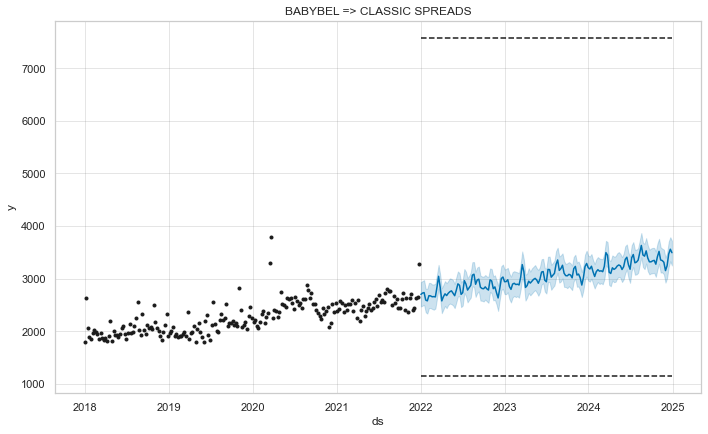

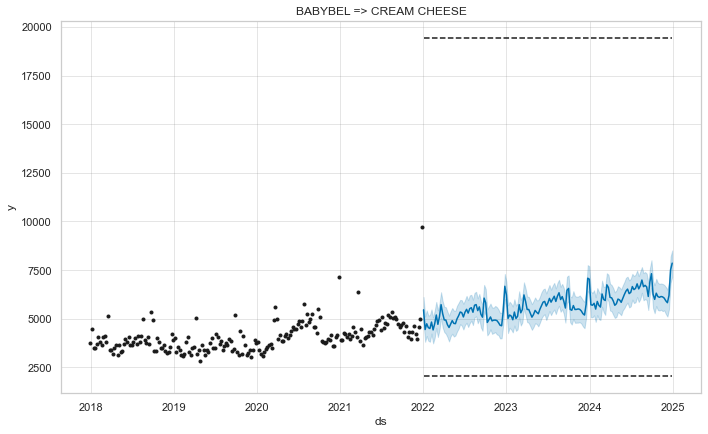

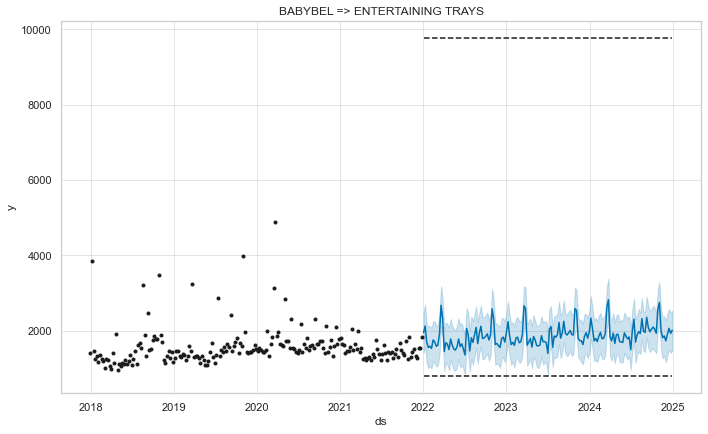

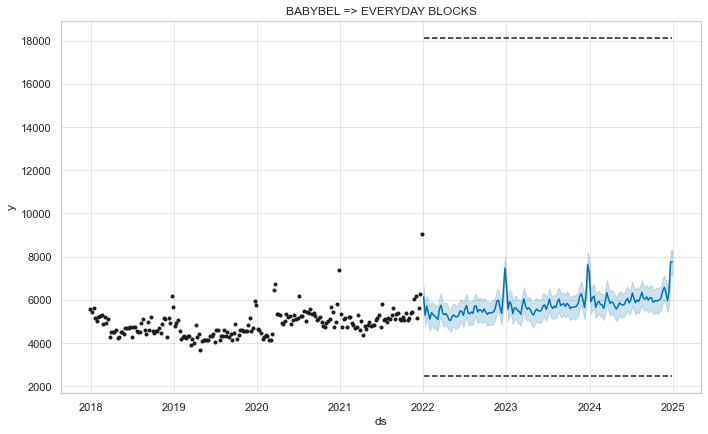

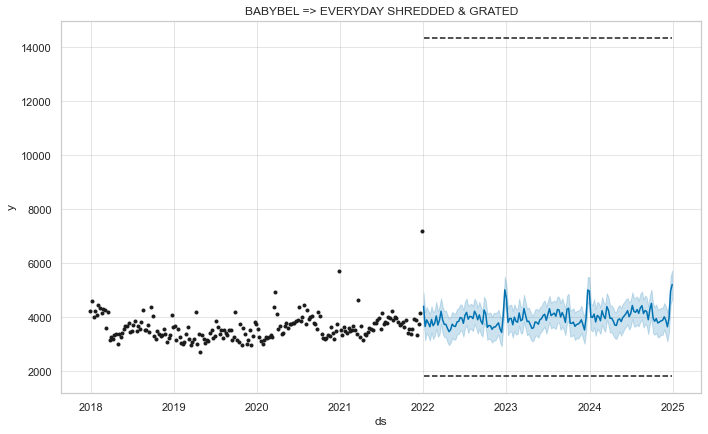

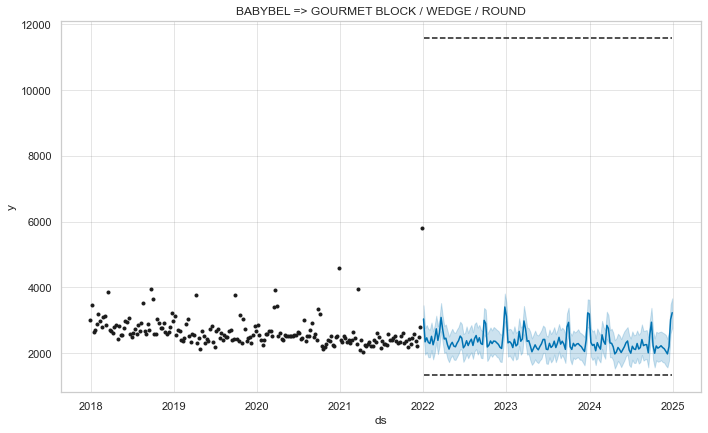

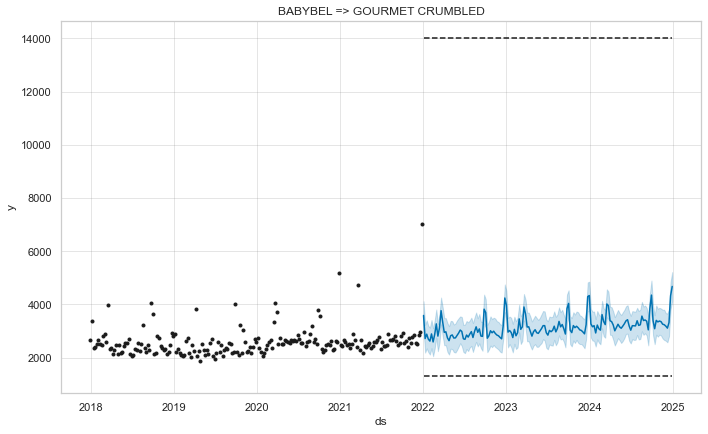

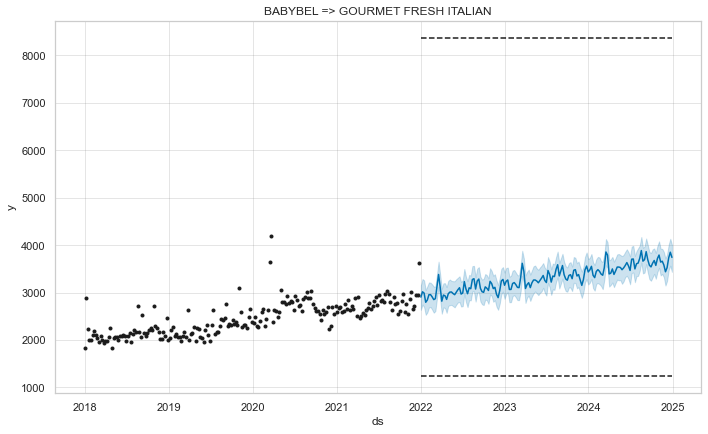

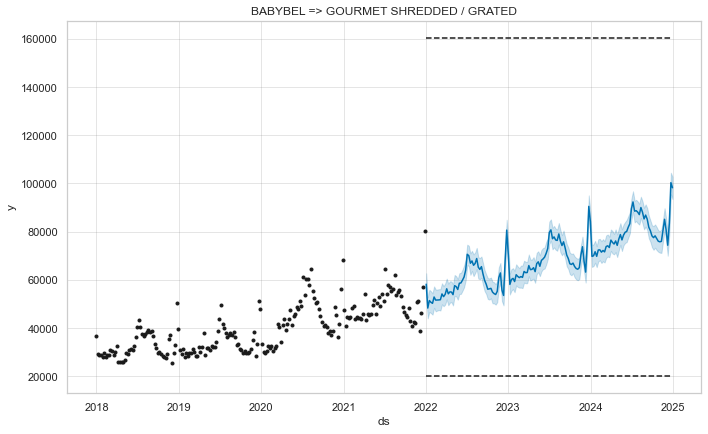

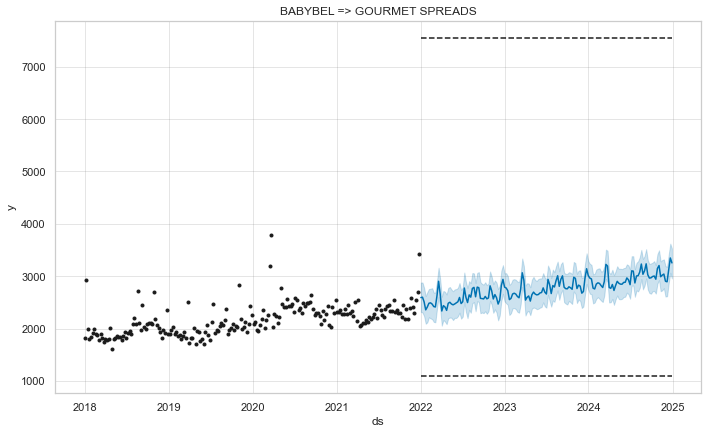

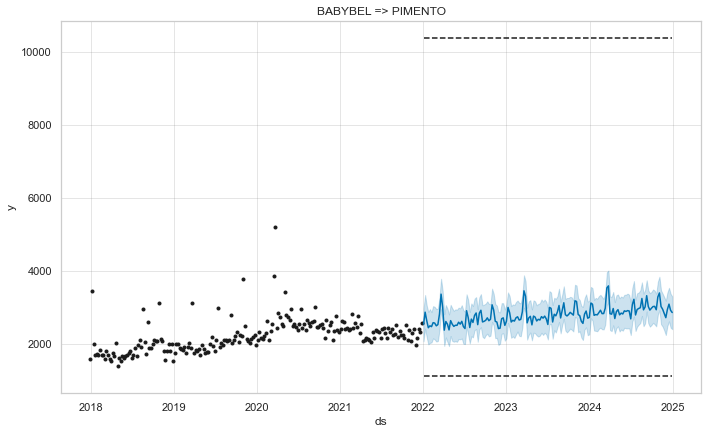

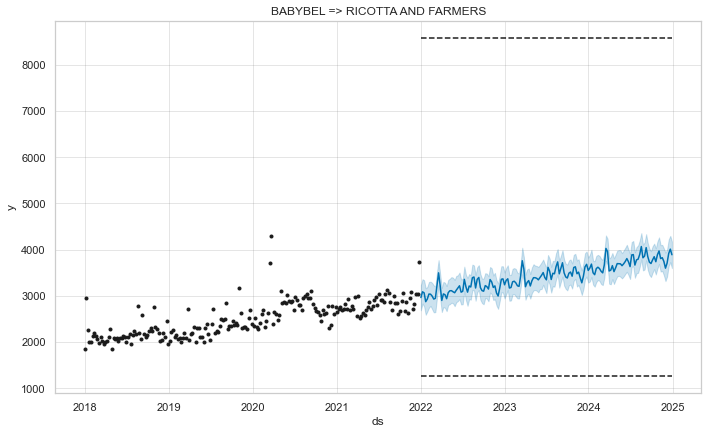

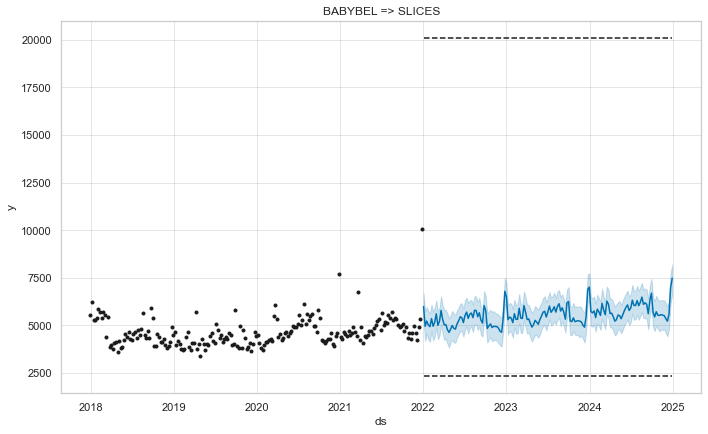

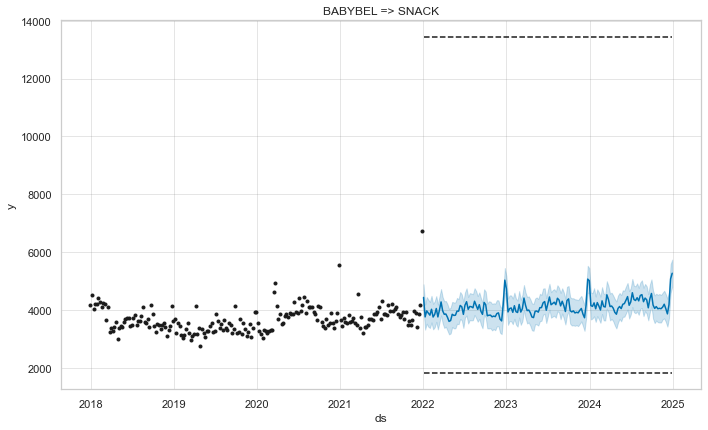

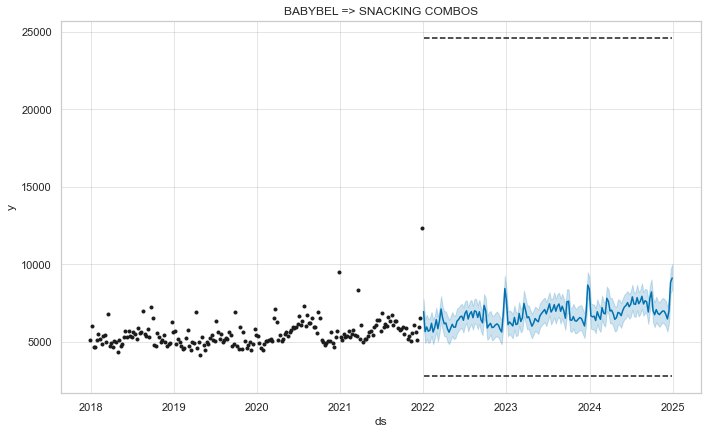

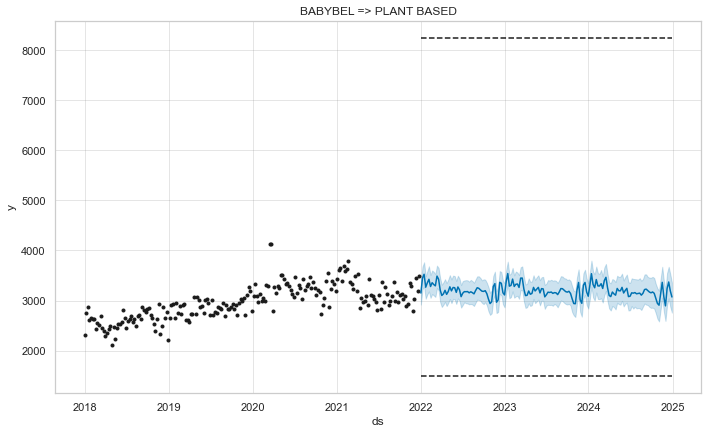

In [18]:
with open('assets/USA_targets_7.json', 'r') as f:
        targets = json.load(f)
for key in targets:
        target = targets.get(key).copy()
        category = target.get('Category')
        p = {
                'Category':le_cat.transform([category])[0],
                'Sub Category':le_sub_cat.transform([target.get('Sub Category')])[0],
                'Brand':le_brand.transform([target.get('Brand')])[0],
                'Number of Categories':target.get('Number of Categories'),
                'Number of Sub Categories':target.get('Number of Sub Categories'),
                'min Distribution':target.get('Distribution') - (target.get('Distribution')*1/20),
                'max Distribution':target.get('Distribution') + (target.get('Distribution')*1/20),
                'mean Distribution':target.get('Distribution'),
                'std Distribution':(target.get('Distribution')*1/100),
                'min Price':target.get('Price per volume') - (target.get('Price per volume')*1/20),
                'max Price':target.get('Price per volume') + (target.get('Price per volume')*1/20),
                'mean Price':target.get('Price per volume'),
                'std Price':(target.get('Price per volume')*1/100),
        }

        nb_samples_per_cat = len(df_sub_no_encoding[df_sub_no_encoding.Category == category])
        ten_per_cent = int(nb_samples_per_cat * 0.1)
        k = ten_per_cent if ten_per_cent >= 100 else nb_samples_per_cat
        
        p = pd.DataFrame(p, index=[0])   
        neighbors = neigh.kneighbors(p, k, return_distance=False)

        profile = build_profile(neighbors[0], df_sub, df_temp, le_brand, le_cat, le_sub_cat)                         
        # Transform series to dataframe
        profile = profile.to_frame().reset_index().rename(columns={'Date': 'ds', 'Sales in volume': 'y'})
        # Forecast with profile
        forecasts = forecast_profile(profile, target, periods=157, freq='W', plot=True)
        
        targets[key]['3Y'] = forecasts[forecasts.ds > profile.ds.iloc[-1]].y.sum()
        print(targets[key]['3Y'])

In [82]:
df_sub_no_encoding.Category.unique()

array(['CLASSIC SPREADS', 'CREAM CHEESE', 'ENTERTAINING TRAYS',
       'EVERYDAY BLOCKS', 'EVERYDAY SHREDDED & GRATED',
       'GOURMET BLOCK / WEDGE / ROUND', 'GOURMET CRUMBLED',
       'GOURMET FRESH ITALIAN', 'GOURMET SHREDDED / GRATED',
       'GOURMET SPREADS', 'PIMENTO', 'PLANT BASED', 'RICOTTA AND FARMERS',
       'SLICES', 'SNACK', 'SNACKING COMBOS'], dtype=object)

In [ ]:
df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']
for key, target in targets.items():
    if target.get('Brand') == 'BABYBEL':
        #print(key)
        if target.get('Category')=='SNACK':
            print(key)
            # if target.get('Sub Category')=='CHEESE DIPPER COMBOS':
            #     print(key)
            #print(le_cat.inverse_transform(target.get('Category')))

In [257]:
targets.get('99')

{'Brand': 'THE LAUGHING COW',
 'Category': 'SNACKING COMBOS',
 'Sub Category': 'CHEESE COMBO WITH MEAT PROTEIN',
 'Number of Categories': 3,
 'Number of Sub Categories': 1.0,
 'Date': '2022-01-01',
 'Period': 1,
 'Distribution': 42.160040802065375,
 'Price per volume': 12.135157741532264,
 'Price per volume without promo': 12.72}

In [80]:
pred = [{'Brand': le_brand.inverse_transform(targets.get(x).get('Brand')), 
         'Category': le_cat.inverse_transform(targets.get(x).get('Category')), 
         '3Y': targets.get(x).get('3Y'),
         'cluster': targets.get(x).get('cluster')
         } for x in targets]

ValueError: y should be a 1d array, got an array of shape () instead.

In [23]:
def make_pretty(styler):
    styler.background_gradient(axis=None)
    return styler


#df_corr.style.pipe(make_pretty)
df_pred = pd.DataFrame(pred)
df_pred['Brand'] = df_pred['Brand'].apply(lambda x:x[0])
df_pred['Category'] = df_pred['Category'].apply(lambda x:x[0])
df_pred['3Y'] = df_pred['3Y'].apply(lambda x:x/1000)
y_pred = df_pred.pivot_table(values='3Y', columns='Category', index='Brand')
y_pred.style.pipe(make_pretty)

Category,CLASSIC SPREADS,CREAM CHEESE,CREAM CHEESE TUBS,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS
Brand,,,,,,,,,,,,,,,,,
BABYBEL,11547.339175,19611.634149,13425.991125,13740.917010,13545.101943,19617.840262,14158.135979,14279.271299,14539.494991,29684.118036,14100.730317,16457.987730,14123.619054,15327.414706,19701.192300,16470.910745,18665.865197
BOURSIN,12365.449439,19360.579971,13999.157570,14385.547602,14013.588339,19428.905901,14393.458615,14755.795711,15352.367399,28046.538014,14684.752542,16462.046537,14806.944447,15948.542133,20451.895640,16804.999337,19880.897498
KAUKAUNA,11468.758708,17500.041845,13105.526527,13030.006966,12859.968969,16249.084846,13250.495725,13481.483972,13360.104724,14722.104669,13224.585637,14300.439152,13524.232438,14900.715202,17022.076554,14178.014396,14416.256101
MERKTS,11814.516437,17541.513718,13639.245376,13696.538702,13569.064540,18016.651919,13848.987434,13962.103560,14137.733905,18267.554934,13826.700068,14909.604499,14212.554746,14675.685232,17556.421474,15527.517185,16365.964791
NURISHH,11490.782008,19873.753594,13841.997211,13816.995487,13449.211288,19750.382050,14238.869870,14416.309362,14467.448494,25399.684128,14201.136316,15748.588678,14358.326266,15125.733994,19226.387546,16761.742107,19493.050054
PRICES,10248.168948,19409.450457,13273.782100,13776.998550,13416.449039,20626.418104,14085.186060,14411.768172,14394.503813,25220.175946,14076.139873,16212.427871,14535.379944,14814.002415,19223.583208,17463.446966,19742.472700
THE LAUGHING COW,9495.845391,18372.588364,11420.026280,11471.558505,11348.724106,18382.121941,11308.012239,11265.072093,13487.577940,21807.244811,11002.297200,14267.765981,11434.231082,13931.736494,18253.676288,13138.802770,13815.030782


In [16]:

#df_pred.to_excel('view/' + 'USA_pred_3Y_7.xlsx')

In [19]:
df = data_manager.get_df()
bel_brands = json_sell_out_params.get('USA').get('bel_brands')
y_true=pd.pivot_table(df[df.Brand.isin(bel_brands)], values='Sales in volume', columns='Category', index='Brand', aggfunc='sum')
y_true = y_true.div(1000)

In [20]:
y_true

Category,CLASSIC SPREADS,GOURMET SPREADS,PIMENTO,PLANT BASED,SNACK,SNACKING COMBOS
Brand,,,,,,
BABYBEL,NaN,NaN,NaN,NaN,80524.784584,1371.573001
BOURSIN,NaN,10885.120322,NaN,42.458153,NaN,NaN
KAUKAUNA,8785.860921,19864.362112,NaN,NaN,67.611856,NaN
MERKTS,12600.546467,NaN,NaN,NaN,62.651540,NaN
NURISHH,NaN,NaN,NaN,8.775062,NaN,NaN
PRICES,NaN,NaN,23719.733877,NaN,18.953260,NaN
THE LAUGHING COW,67.794016,NaN,NaN,NaN,46407.430180,4714.037257


In [273]:
4714.037257/4

1178.50931425

In [28]:
#y_pred[~y_true.isna()] = None
(y_pred + y_pred.multiply(1/3))

Category,CLASSIC SPREADS,CREAM CHEESE,CREAM CHEESE TUBS,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS
Brand,,,,,,,,,,,,,,,,,
BABYBEL,15396.452233,26148.845532,17901.321499,18321.222680,18060.135924,26157.120349,18877.514638,19039.028398,19385.993322,39578.824048,18800.973756,21943.983639,18831.492072,20436.552941,26268.256400,21961.214326,24887.820263
BOURSIN,16487.265919,25814.106628,18665.543427,19180.730135,18684.784452,25905.207868,19191.278153,19674.394281,20469.823199,37395.384019,19579.670056,21949.395382,19742.592595,21264.722844,27269.194187,22406.665783,26507.863330
KAUKAUNA,15291.678278,23333.389127,17474.035369,17373.342621,17146.625292,21665.446461,17667.327634,17975.311962,17813.472965,19629.472892,17632.780849,19067.252203,18032.309917,19867.620270,22696.102072,18904.019194,19221.674801
MERKTS,15752.688583,23388.684957,18185.660501,18262.051603,18092.086053,24022.202559,18465.316579,18616.138080,18850.311873,24356.739912,18435.600091,19879.472665,18950.072994,19567.580310,23408.561965,20703.356246,21821.286389
NURISHH,15321.042677,26498.338125,18455.996281,18422.660649,17932.281718,26333.842734,18985.159826,19221.745816,19289.931326,33866.245504,18934.848422,20998.118237,19144.435021,20167.645325,25635.183394,22348.989476,25990.733405
PRICES,13664.225265,25879.267277,17698.376133,18369.331400,17888.598719,27501.890805,18780.248080,19215.690897,19192.671750,33626.901262,18768.186497,21616.570495,19380.506592,19752.003220,25631.444277,23284.595955,26323.296933
THE LAUGHING COW,12661.127188,24496.784486,15226.701706,15295.411339,15131.632142,24509.495921,15077.349652,15020.096124,17983.437253,29076.326415,14669.729600,19023.687974,15245.641443,18575.648658,24338.235050,17518.403693,18420.041043


In [25]:
y_pred

Category,CLASSIC SPREADS,CREAM CHEESE,CREAM CHEESE TUBS,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS
Brand,,,,,,,,,,,,,,,,,
BABYBEL,11547.339175,19611.634149,13425.991125,13740.917010,13545.101943,19617.840262,14158.135979,14279.271299,14539.494991,29684.118036,14100.730317,16457.987730,14123.619054,15327.414706,19701.192300,16470.910745,18665.865197
BOURSIN,12365.449439,19360.579971,13999.157570,14385.547602,14013.588339,19428.905901,14393.458615,14755.795711,15352.367399,28046.538014,14684.752542,16462.046537,14806.944447,15948.542133,20451.895640,16804.999337,19880.897498
KAUKAUNA,11468.758708,17500.041845,13105.526527,13030.006966,12859.968969,16249.084846,13250.495725,13481.483972,13360.104724,14722.104669,13224.585637,14300.439152,13524.232438,14900.715202,17022.076554,14178.014396,14416.256101
MERKTS,11814.516437,17541.513718,13639.245376,13696.538702,13569.064540,18016.651919,13848.987434,13962.103560,14137.733905,18267.554934,13826.700068,14909.604499,14212.554746,14675.685232,17556.421474,15527.517185,16365.964791
NURISHH,11490.782008,19873.753594,13841.997211,13816.995487,13449.211288,19750.382050,14238.869870,14416.309362,14467.448494,25399.684128,14201.136316,15748.588678,14358.326266,15125.733994,19226.387546,16761.742107,19493.050054
PRICES,10248.168948,19409.450457,13273.782100,13776.998550,13416.449039,20626.418104,14085.186060,14411.768172,14394.503813,25220.175946,14076.139873,16212.427871,14535.379944,14814.002415,19223.583208,17463.446966,19742.472700
THE LAUGHING COW,9495.845391,18372.588364,11420.026280,11471.558505,11348.724106,18382.121941,11308.012239,11265.072093,13487.577940,21807.244811,11002.297200,14267.765981,11434.231082,13931.736494,18253.676288,13138.802770,13815.030782


In [26]:
y_true

Category,CLASSIC SPREADS,GOURMET SPREADS,PIMENTO,PLANT BASED,SNACK,SNACKING COMBOS
Brand,,,,,,
BABYBEL,NaN,NaN,NaN,NaN,80524.784584,1371.573001
BOURSIN,NaN,10885.120322,NaN,42.458153,NaN,NaN
KAUKAUNA,8785.860921,19864.362112,NaN,NaN,67.611856,NaN
MERKTS,12600.546467,NaN,NaN,NaN,62.651540,NaN
NURISHH,NaN,NaN,NaN,8.775062,NaN,NaN
PRICES,NaN,NaN,23719.733877,NaN,18.953260,NaN
THE LAUGHING COW,67.794016,NaN,NaN,NaN,46407.430180,4714.037257


In [ ]:
#data_manager.df[data_manager.df.Brand.isin(bel_brands)].groupby(['Brand', 'Category'])['Sales in volume'].agg('sum')/1000

Brand             Category                  
BABYBEL           SNACK                         80524.784584
                  SNACKING COMBOS                1371.573001
BOURSIN           GOURMET                       10885.298255
                  PLANT BASED                      42.458153
KAUKAUNA          CLASSIC SPREADS                8785.860921
                  GOURMET                       19863.413786
                  SNACK                            67.611856
MERKTS            CLASSIC SPREADS               12600.546467
                  SNACK                            62.651540
NURISHH           EVERYDAY SHREDDED & GRATED        4.457501
                  PLANT BASED                       8.775062
                  SLICES                            4.317561
PRICES            PIMENTO                       23719.733877
                  SNACK                            18.953260
THE LAUGHING COW  CLASSIC SPREADS                  67.794016
                  PLANT BASED           

In [280]:
time_serie = df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']['Sales in volume']

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/595029084.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  time_serie = df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS']['Sales in volume']


In [271]:
df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS'][['Distribution', 'Price per volume']].agg('std')

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_19476/3599048565.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Brand=='THE LAUGHING COW'][df.Category=='SNACKING COMBOS'][df['Sub Category']=='CHEESE DIPPER COMBOS'][['Distribution', 'Price per volume']].agg('std')


Distribution        21.537048
Price per volume     0.767633
dtype: float64

In [282]:
time_serie.reset_index(drop=True)

0      20370.255253
1      31423.449508
2      44740.601942
3      38353.966531
4      43025.658107
           ...     
204     9814.594167
205     8207.155612
206     8376.817670
207     7787.803257
208     5896.800917
Name: Sales in volume, Length: 209, dtype: float64